# The Louvain Algorithm for Community Detection

## Introduction

The Louvain algorithm is one of the most popular and efficient methods for detecting communities in large networks. Developed by Blondel et al. in 2008, it's become widely used because of its excellent performance characteristics:

- Fast execution time (near-linear complexity)
- High-quality community detection (high modularity scores)
- Hierarchical community structure detection
- Ability to work with weighted and directed networks

This notebook explores how the Louvain algorithm works and demonstrates it with practical examples using NetworkX.

In [1]:
# Import necessary libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import warnings
warnings.filterwarnings('ignore')

# Set plot parameters for better visualization
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Define a pastel color palette using matplotlib colormap
pastel_cmap = plt.cm.Pastel1

## Understanding the Louvain Algorithm

The Louvain algorithm is a hierarchical community detection method that optimizes modularity through an iterative two-phase process:

### Phase 1: Local Modularity Optimization
- Start with each node in its own community
- For each node i (in random order):
  - Remove i from its current community
  - Place i in the neighboring community that yields the highest modularity gain
  - If no positive gain is possible, keep i in its original community
- Repeat until no further improvement can be made

### Phase 2: Network Aggregation
- Build a new network where:
  - Nodes are the communities found in Phase 1
  - Edge weights between new nodes are the sum of weights between nodes in the corresponding communities
  - Self-loops represent internal connections within communities

### Full Algorithm
- Apply Phase 1 to the initial network
- Apply Phase 2 to create a condensed network
- Repeat Phases 1 and 2 on the condensed network until no further modularity improvement is possible

### Key Concept: Modularity

Modularity (Q) measures the density of links inside communities compared to links between communities:

$$Q = \frac{1}{2m}\sum_{i,j} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$$

Where:
- $A_{ij}$ is the adjacency matrix element (1 if nodes i,j are connected, 0 otherwise)
- $k_i, k_j$ are the degrees of nodes i and j
- $2m$ is the total number of edges in the network
- $\delta(c_i, c_j)$ is 1 if nodes i and j belong to the same community, 0 otherwise

## Practical Application: Zachary's Karate Club

Let's apply NetworkX's implementation of the Louvain algorithm to Zachary's Karate Club network, a classic benchmark for community detection.

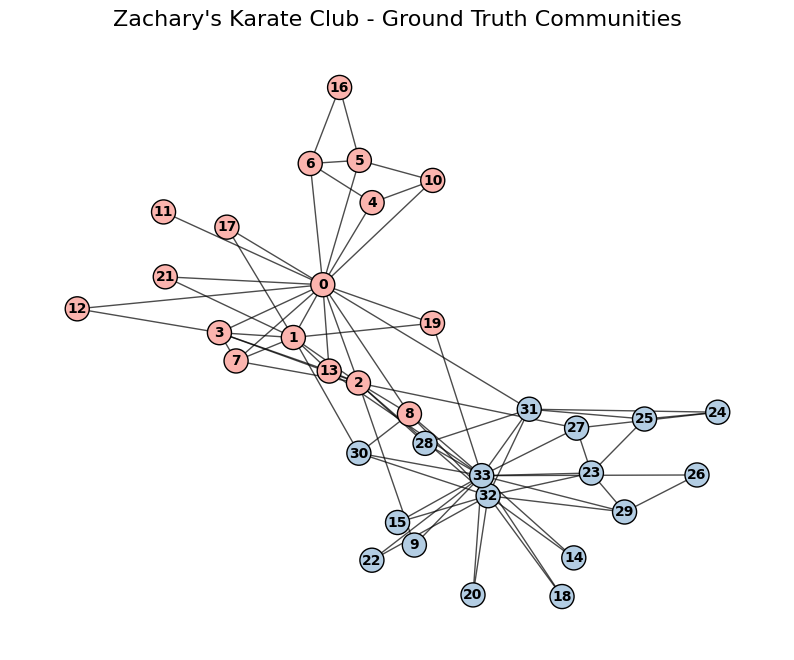

In [2]:
# Load Zachary's Karate Club network
G = nx.karate_club_graph()

# Get ground truth communities (instructor = 0, administrator = 1)
ground_truth = {}
for node in G.nodes():
    ground_truth[node] = 0 if G.nodes[node]['club'] == 'Mr. Hi' else 1

# Visualize the ground truth communities
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Consistent layout
colors = [pastel_cmap(ground_truth[node]) for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=300, edgecolors='black')
nx.draw_networkx_edges(G, pos, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Zachary's Karate Club - Ground Truth Communities", fontsize=16)
plt.axis('off')
plt.show()

Number of communities detected: 4
Modularity: 0.4266

Communities:
Community 1: [1, 2, 3, 7, 12, 13]
Community 2: [0, 4, 5, 6, 10, 11, 16, 17, 19, 21]
Community 3: [24, 25, 28, 31]
Community 4: [8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33]


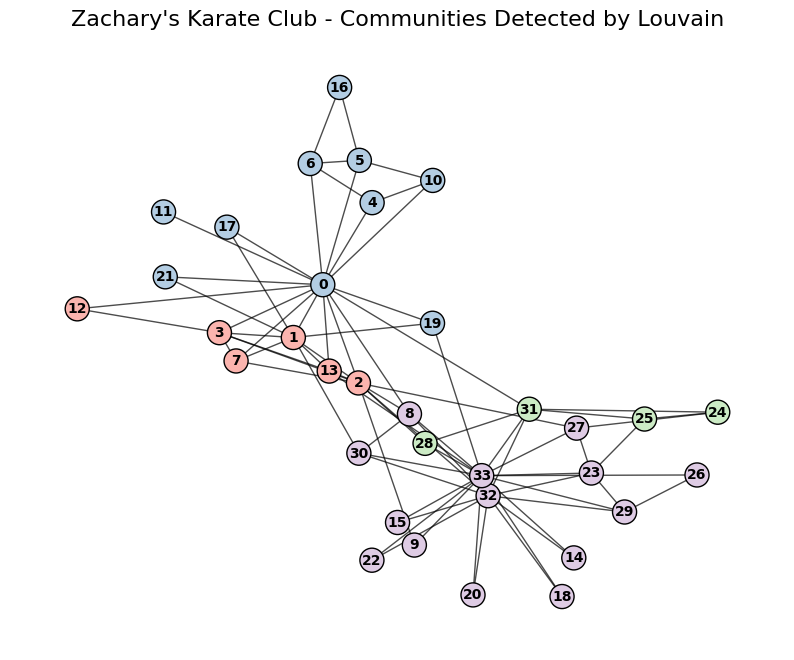

In [3]:
# Apply NetworkX's implementation of Louvain algorithm
communities = list(nx.community.louvain_communities(G, seed=42))
best_partition = {node: i for i, comm in enumerate(communities) for node in comm}

# Calculate modularity
modularity = nx.community.modularity(G, communities)

# Group nodes by community
community_to_nodes = {}
for node, community_id in best_partition.items():
    if community_id not in community_to_nodes:
        community_to_nodes[community_id] = []
    community_to_nodes[community_id].append(node)

print(f"Number of communities detected: {len(community_to_nodes)}")
print(f"Modularity: {modularity:.4f}")
print("\nCommunities:")
for community_id, nodes in community_to_nodes.items():
    print(f"Community {community_id+1}: {sorted(nodes)}")

# Visualize the detected communities
plt.figure(figsize=(10, 8))
colors = [pastel_cmap(best_partition[node] % pastel_cmap.N) for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=300, edgecolors='black')
nx.draw_networkx_edges(G, pos, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Zachary's Karate Club - Communities Detected by Louvain", fontsize=16)
plt.axis('off')
plt.show()

## The Effect of Resolution Parameter

The Louvain algorithm in NetworkX includes a resolution parameter that controls the size of detected communities. Lower values tend to produce larger communities, while higher values result in smaller, more numerous communities.

Resolution: 0.5, Communities: 2, Modularity: 0.4036
Resolution: 1.0, Communities: 4, Modularity: 0.4266
Resolution: 1.5, Communities: 5, Modularity: 0.4181


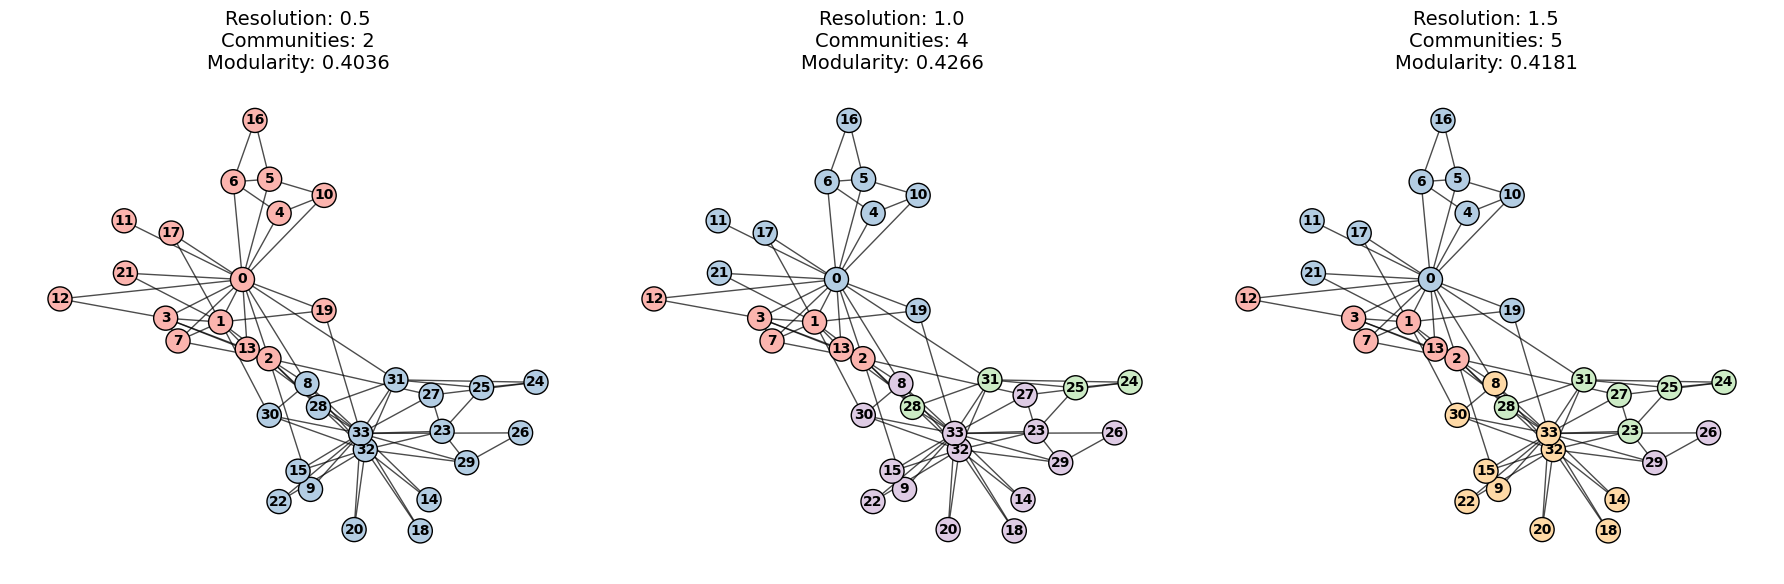

In [4]:
def apply_louvain_at_resolution(G, resolution):
    """Apply Louvain algorithm with a specific resolution parameter"""
    communities = list(nx.community.louvain_communities(G, resolution=resolution, seed=42))
    partition = {node: i for i, comm in enumerate(communities) for node in comm}
    modularity = nx.community.modularity(G, communities)
    return partition, modularity, communities

# Test different resolution parameters
resolutions = [0.5, 1.0, 1.5]
results = []

for resolution in resolutions:
    partition, modularity, communities = apply_louvain_at_resolution(G, resolution)
    
    # Count communities
    num_communities = len(communities)
    
    results.append((resolution, num_communities, modularity, partition))
    
    print(f"Resolution: {resolution}, Communities: {num_communities}, Modularity: {modularity:.4f}")

# Visualize results at different resolutions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (resolution, num_communities, modularity, partition) in enumerate(results):
    ax = axes[i]
    colors = [pastel_cmap(partition[node] % pastel_cmap.N) for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=300, edgecolors='black', ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.7, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax)
    
    ax.set_title(f"Resolution: {resolution}\nCommunities: {num_communities}\nModularity: {modularity:.4f}", fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Comparing with Ground Truth

Let's compare the communities detected by the Louvain algorithm with the ground truth division of the Karate Club using standard metrics.

### Adjusted Rand Index (ARI)

The Adjusted Rand Index measures the similarity between two clusterings, adjusted for chance. It ranges from -1 to 1:
- 1: Perfect agreement between the partitions
- 0: Agreement equivalent to random chance
- Negative values: Agreement worse than random chance

Let's also use Normalized Mutual Information (NMI), another measure of clustering agreement that ranges from 0 to 1.

In [5]:
def calculate_metrics(ground_truth, partition):
    """Calculate metrics comparing ground truth and detected communities"""
    # Convert dictionaries to lists for sklearn metrics
    ground_truth_list = [ground_truth[node] for node in sorted(ground_truth.keys())]
    partition_list = [partition[node] for node in sorted(partition.keys())]
    
    ari = adjusted_rand_score(ground_truth_list, partition_list)
    nmi = normalized_mutual_info_score(ground_truth_list, partition_list)
    
    return ari, nmi

# Analyze each partition against ground truth
print("Comparison with ground truth communities:")
print("-" * 60)
print(f"{'Resolution':^12} | {'Communities':^14} | {'ARI':^8} | {'NMI':^8}")
print("-" * 60)

best_resolution = None
best_ari = -1
best_partition = None

for resolution, num_communities, modularity, partition in results:
    ari, nmi = calculate_metrics(ground_truth, partition)
    print(f"{resolution:^12} | {num_communities:^14} | {ari:.4f} | {nmi:.4f}")
    
    if ari > best_ari:
        best_ari = ari
        best_resolution = resolution
        best_partition = partition

print(f"\nBest resolution: {best_resolution} with ARI: {best_ari:.4f}")

Comparison with ground truth communities:
------------------------------------------------------------
 Resolution  |  Communities   |   ARI    |   NMI   
------------------------------------------------------------
    0.5      |       2        | 0.8823 | 0.8372
    1.0      |       4        | 0.4905 | 0.5942
    1.5      |       5        | 0.3869 | 0.5452

Best resolution: 0.5 with ARI: 0.8823


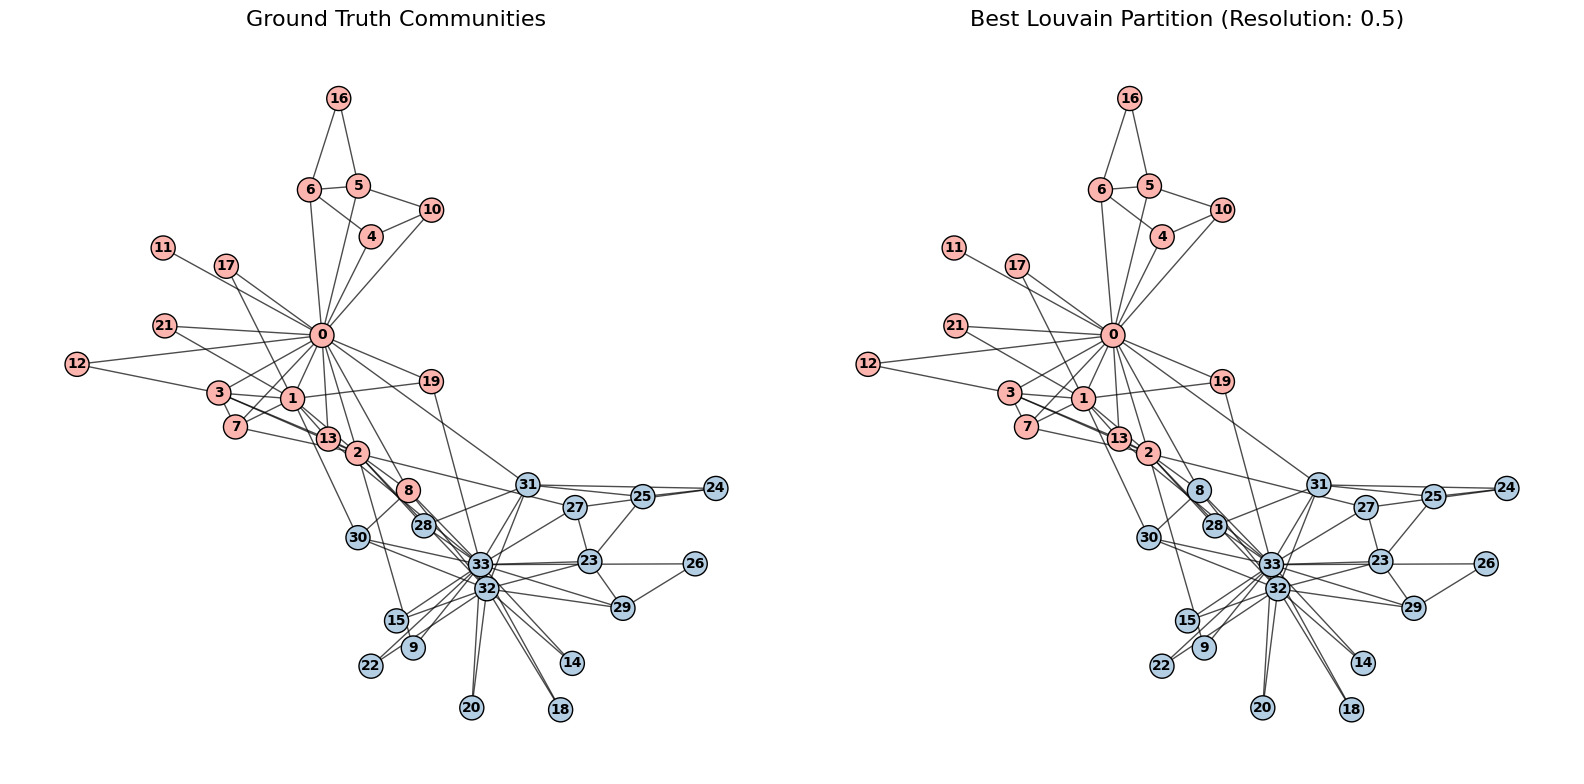

In [6]:
# Visualize ground truth vs. best partition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Ground truth
colors1 = [pastel_cmap(ground_truth[node]) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=colors1, node_size=300, edgecolors='black', ax=ax1)
nx.draw_networkx_edges(G, pos, alpha=0.7, ax=ax1)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax1)
ax1.set_title("Ground Truth Communities", fontsize=16)
ax1.axis('off')

# Best partition
colors2 = [pastel_cmap(best_partition[node] % pastel_cmap.N) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=colors2, node_size=300, edgecolors='black', ax=ax2)
nx.draw_networkx_edges(G, pos, alpha=0.7, ax=ax2)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax2)
ax2.set_title(f"Best Louvain Partition (Resolution: {best_resolution})", fontsize=16)
ax2.axis('off')

plt.tight_layout()
plt.show()

## Analyzing Misclassified Nodes

Let's identify which nodes are assigned to different communities compared to the ground truth and analyze their network properties:

Number of misclassified nodes: 1
Misclassified nodes: [8]


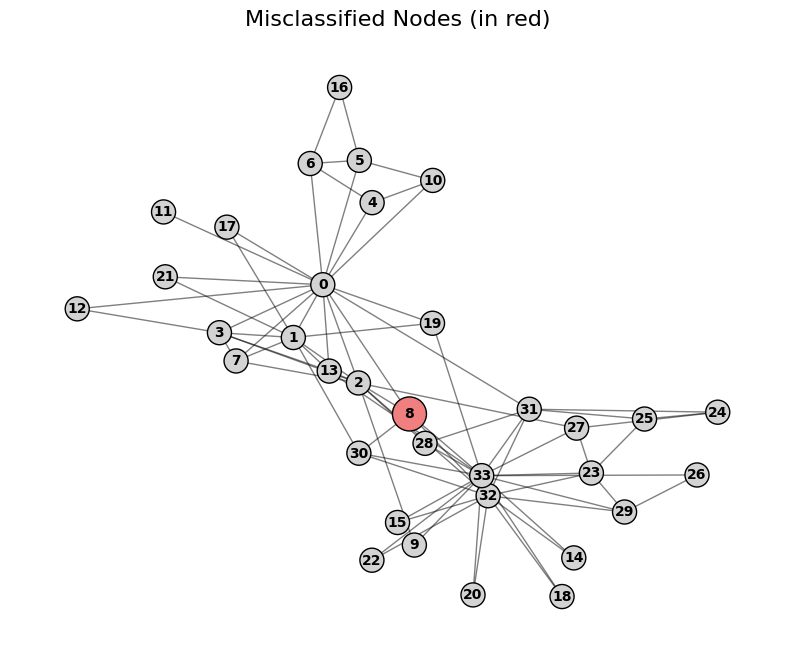

In [7]:
# Map detected communities to ground truth communities
community_to_ground_truth = {}
for node, community in best_partition.items():
    if community not in community_to_ground_truth:
        community_to_ground_truth[community] = []
    community_to_ground_truth[community].append(ground_truth[node])

# Determine the dominant ground truth community for each detected community
dominant_ground_truth = {}
for community, gt_values in community_to_ground_truth.items():
    counts = {0: gt_values.count(0), 1: gt_values.count(1)}
    dominant_ground_truth[community] = max(counts, key=counts.get)

# Find misclassified nodes
misclassified = []
for node, community in best_partition.items():
    expected_gt = dominant_ground_truth[community]
    actual_gt = ground_truth[node]
    if expected_gt != actual_gt:
        misclassified.append(node)

print(f"Number of misclassified nodes: {len(misclassified)}")
print(f"Misclassified nodes: {sorted(misclassified)}")

# Visualize misclassified nodes
plt.figure(figsize=(10, 8))
node_colors = []
for node in G.nodes():
    if node in misclassified:
        node_colors.append('lightcoral')  # Light red for misclassified
    else:
        node_colors.append('lightgray')  # Light grey for correctly classified

node_sizes = [600 if node in misclassified else 300 for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black')
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Misclassified Nodes (in red)", fontsize=16)
plt.axis('off')
plt.show()

## Analyzing the Structural Properties of Misclassified Nodes

Let's examine why certain nodes are misclassified by looking at their structural properties in the network:

In [8]:
# Calculate topological properties for each node
node_metrics = {}
for node in G.nodes():
    # Calculate number of connections to each ground truth community
    connections_to_0 = sum(1 for neighbor in G.neighbors(node) if ground_truth[neighbor] == 0)
    connections_to_1 = sum(1 for neighbor in G.neighbors(node) if ground_truth[neighbor] == 1)
    
    # Calculate network metrics
    betweenness = nx.betweenness_centrality(G)[node]
    clustering = nx.clustering(G, node)
    
    node_metrics[node] = {
        'degree': G.degree[node],
        'connections_to_0': connections_to_0,
        'connections_to_1': connections_to_1,
        'betweenness': betweenness,
        'clustering': clustering,
        'ground_truth': ground_truth[node],
        'louvain_community': best_partition[node],
        'misclassified': node in misclassified
    }

# Display metrics for misclassified nodes
print("Metrics for misclassified nodes:")
print("-" * 80)
print(f"{'Node':^6} | {'Degree':^6} | {'Connects to C0':^14} | {'Connects to C1':^14} | {'Betweenness':^12} | {'Clustering':^10}")
print("-" * 80)

for node in sorted(misclassified):
    metrics = node_metrics[node]
    ratio0 = metrics['connections_to_0'] / metrics['degree']
    ratio1 = metrics['connections_to_1'] / metrics['degree']
    
    print(f"{node:^6} | {metrics['degree']:^6} | {metrics['connections_to_0']:^5} ({ratio0:.2f}) | {metrics['connections_to_1']:^5} ({ratio1:.2f}) | {metrics['betweenness']:.4f} | {metrics['clustering']:.4f}")

# Analyze boundary nodes (nodes with significant connections to both communities)
boundary_nodes = []
for node, metrics in node_metrics.items():
    ratio0 = metrics['connections_to_0'] / metrics['degree']
    ratio1 = metrics['connections_to_1'] / metrics['degree']
    if ratio0 > 0.3 and ratio1 > 0.3:  # Significant connections to both communities
        boundary_nodes.append(node)

print(f"\nBoundary nodes (connecting both communities): {sorted(boundary_nodes)}")

Metrics for misclassified nodes:
--------------------------------------------------------------------------------
 Node  | Degree | Connects to C0 | Connects to C1 | Betweenness  | Clustering
--------------------------------------------------------------------------------
  8    |   5    |   2   (0.40) |   3   (0.60) | 0.0559 | 0.5000

Boundary nodes (connecting both communities): [2, 8, 9, 19, 28, 30]


## Resolution Limit Analysis

One limitation of modularity maximization methods like Louvain is the "resolution limit" - they may fail to detect small communities. Let's analyze this effect using a synthetic network with clear community structure at different scales:

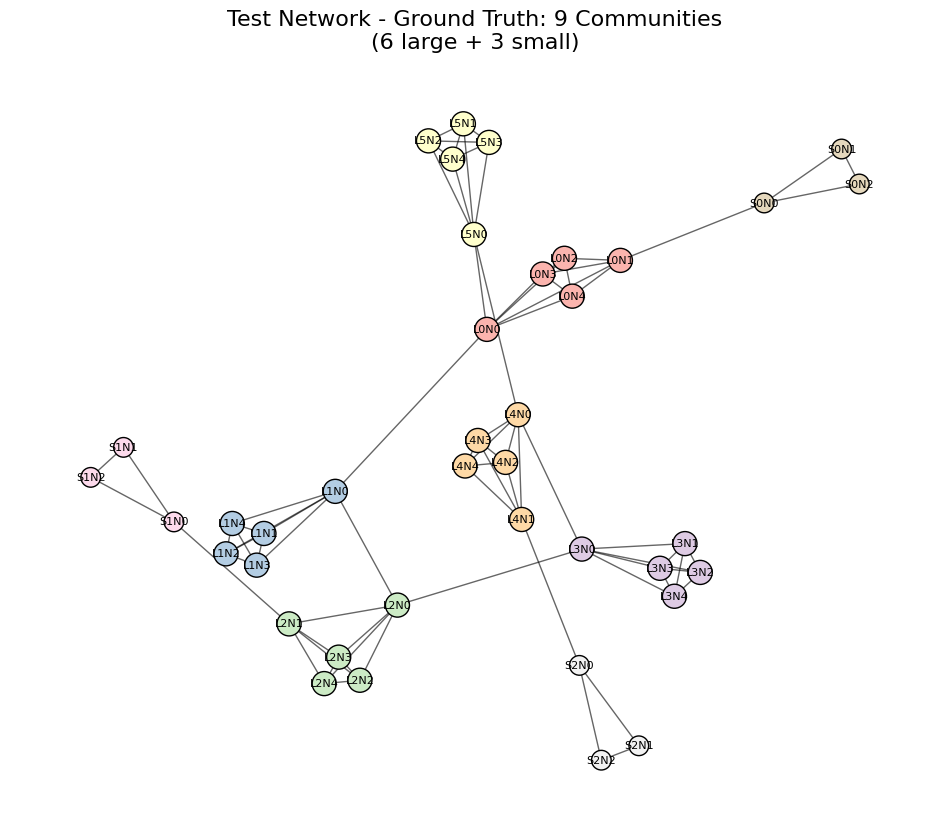

In [9]:
# Create a synthetic network with clear community structure at different scales
def create_ring_of_cliques(num_cliques, clique_size, extra_connections=1):
    """Create a network consisting of a ring of cliques"""
    G = nx.Graph()
    # Create cliques
    for i in range(num_cliques):
        nodes = [f"C{i}N{j}" for j in range(clique_size)]
        G.add_nodes_from(nodes, community=i)
        # Add edges within clique (complete graph within each clique)
        for u in range(len(nodes)):
            for v in range(u+1, len(nodes)):
                G.add_edge(nodes[u], nodes[v])
    
    # Connect the cliques in a ring
    for i in range(num_cliques):
        next_clique = (i + 1) % num_cliques
        # Add extra_connections edges between consecutive cliques
        for j in range(extra_connections):
            G.add_edge(f"C{i}N{j}", f"C{next_clique}N{j}")
    
    return G

# Create a test network with communities at different scales
def create_test_network():
    G = nx.Graph()
    
    # Create 6 large cliques (5 nodes each) in a ring
    for i in range(6):
        nodes_large = [f"L{i}N{j}" for j in range(5)]
        G.add_nodes_from(nodes_large, community=i, size="large")
        # Make each clique a complete graph
        for u in range(len(nodes_large)):
            for v in range(u+1, len(nodes_large)):
                G.add_edge(nodes_large[u], nodes_large[v])
    
    # Connect the large cliques in a ring
    for i in range(6):
        next_clique = (i + 1) % 6
        G.add_edge(f"L{i}N0", f"L{next_clique}N0")
    
    # Add 3 small cliques (3 nodes each) with weak connections
    for i in range(3):
        nodes_small = [f"S{i}N{j}" for j in range(3)]
        G.add_nodes_from(nodes_small, community=i+6, size="small")
        # Make each small clique a complete graph
        for u in range(len(nodes_small)):
            for v in range(u+1, len(nodes_small)):
                G.add_edge(nodes_small[u], nodes_small[v])
    
    # Connect small cliques to large ones with single edges
    G.add_edge("S0N0", "L0N1")
    G.add_edge("S1N0", "L2N1")
    G.add_edge("S2N0", "L4N1")
    
    return G

# Create test network and visualize
test_network = create_test_network()
test_pos = nx.spring_layout(test_network, seed=42)

plt.figure(figsize=(12, 10))
# Color nodes by ground truth community
gt_colors = [pastel_cmap(test_network.nodes[node]['community'] % pastel_cmap.N) for node in test_network.nodes()]
node_sizes = [300 if test_network.nodes[node]['size'] == 'large' else 200 for node in test_network.nodes()]

nx.draw_networkx_nodes(test_network, test_pos, node_color=gt_colors, node_size=node_sizes, edgecolors='black')
nx.draw_networkx_edges(test_network, test_pos, alpha=0.6)
nx.draw_networkx_labels(test_network, test_pos, font_size=8)

plt.title("Test Network - Ground Truth: 9 Communities\n(6 large + 3 small)", fontsize=16)
plt.axis('off')
plt.show()

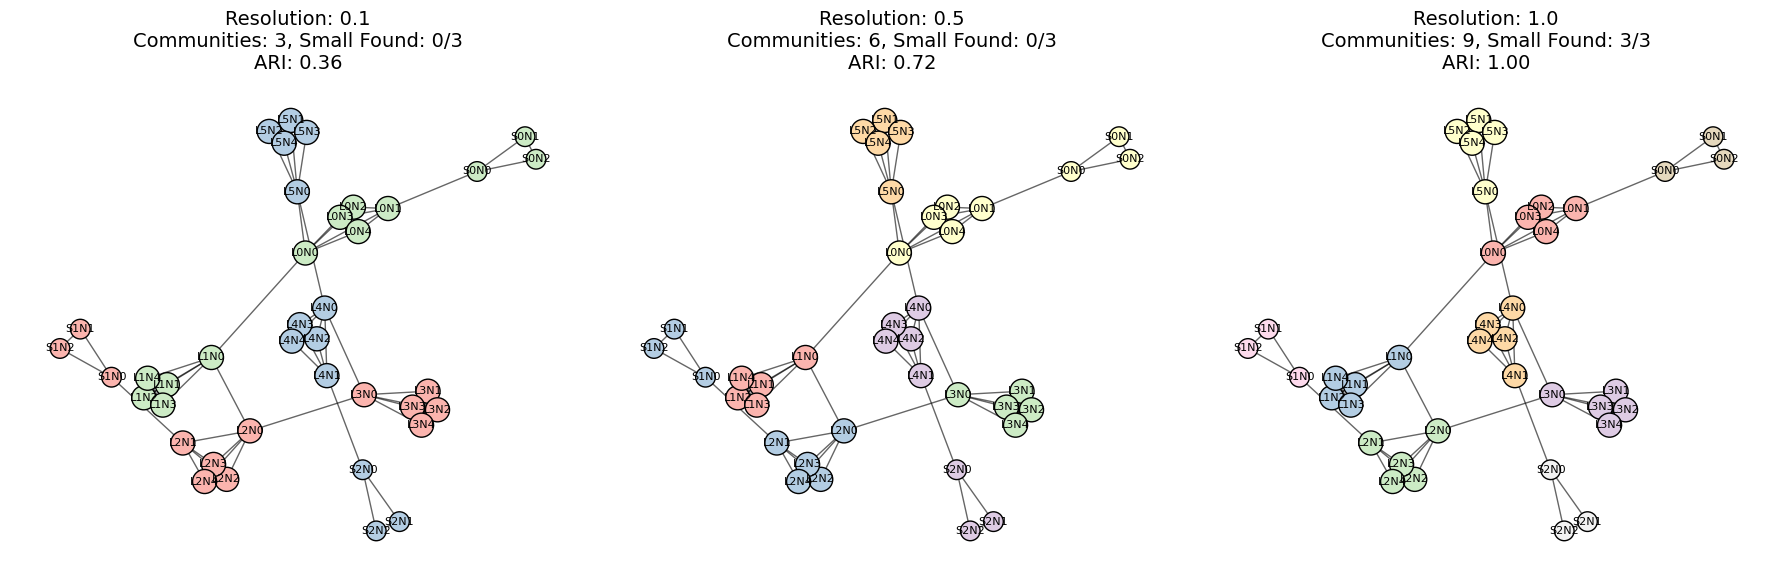

Analysis of Community Sizes at Different Resolutions:
------------------------------------------------------------------------------------------
Resolution | Communities  | Small Found  |  Min Size  |  Max Size  |  Avg Size  |   ARI   
------------------------------------------------------------------------------------------
   0.1     |      3       |      0       |     13     |     13     |   13.00    |  0.3640 
   0.5     |      6       |      0       |     5      |     8      |    6.50    |  0.7218 
   1.0     |      9       |      3       |     3      |     5      |    4.33    |  1.0000 


In [10]:
# Apply Louvain at different resolutions
# Use only three values as requested: 0.1, 0.5, 1.0
resolutions = [0.1, 0.5, 1.0]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Get ground truth communities
ground_truth = {node: test_network.nodes[node]['community'] for node in test_network.nodes()}

# For storing results
results_table = []

# Apply Louvain at different resolutions
for i, resolution in enumerate(resolutions):
    ax = axes[i]
    
    # Apply Louvain
    communities = list(nx.community.louvain_communities(test_network, resolution=resolution, seed=42))
    partition = {node: i for i, comm in enumerate(communities) for node in comm}
    modularity = nx.community.modularity(test_network, communities)
    
    # Count communities
    num_communities = len(communities)
    
    # Analyze how many small communities were correctly identified
    small_communities_found = 0
    for comm_id in set(partition.values()):
        nodes_in_comm = [n for n, c in partition.items() if c == comm_id]
        if all(n.startswith('S') for n in nodes_in_comm):
            small_communities_found += 1
    
    # Calculate metrics comparing to ground truth
    ari, nmi = calculate_metrics(ground_truth, partition)
    
    # Store results for table
    comm_sizes = [len(comm) for comm in communities]
    results_table.append({
        'resolution': resolution,
        'communities': num_communities,
        'small_found': small_communities_found,
        'min_size': min(comm_sizes),
        'max_size': max(comm_sizes),
        'avg_size': sum(comm_sizes)/len(comm_sizes),
        'ari': ari
    })
    
    # Visualize
    colors = [pastel_cmap(partition[node] % pastel_cmap.N) for node in test_network.nodes()]
    nx.draw_networkx_nodes(test_network, test_pos, node_color=colors, node_size=node_sizes, edgecolors='black', ax=ax)
    nx.draw_networkx_edges(test_network, test_pos, alpha=0.6, ax=ax)
    nx.draw_networkx_labels(test_network, test_pos, font_size=8, ax=ax)
    
    ax.set_title(f"Resolution: {resolution}\nCommunities: {num_communities}, Small Found: {small_communities_found}/3\nARI: {ari:.2f}", fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Display results table
print("Analysis of Community Sizes at Different Resolutions:")
print("-" * 90)
print(f"{'Resolution':^10} | {'Communities':^12} | {'Small Found':^12} | {'Min Size':^10} | {'Max Size':^10} | {'Avg Size':^10} | {'ARI':^8}")
print("-" * 90)

for result in results_table:
    print(f"{result['resolution']:^10} | {result['communities']:^12} | {result['small_found']:^12} | {result['min_size']:^10} | {result['max_size']:^10} | {result['avg_size']:^10.2f} | {result['ari']:^8.4f}")

## Conclusion

### Strengths of the Louvain Algorithm

1. **Computational Efficiency**: The Louvain algorithm can process large networks with millions of nodes and edges in reasonable time.

2. **Hierarchical Detection**: The algorithm naturally reveals multilevel community structures by using the resolution parameter.

3. **No Predetermined Community Number**: Unlike some clustering algorithms, Louvain automatically determines the appropriate number of communities.

4. **High Quality Results**: Typically produces partitions with high modularity scores that reflect meaningful community structure.

### Limitations

1. **Resolution Limit**: Like other modularity-based methods, Louvain has difficulty detecting communities smaller than a scale dependent on network size.

2. **Degeneracy**: Multiple different partitions may have similar modularity scores, leading to potential instability in results.

3. **Local Optima**: As a greedy algorithm, Louvain may get trapped in local optima rather than finding the global optimum.

### Key Takeaways

- The Louvain algorithm is an efficient tool for community detection that balances computational speed with result quality.
- The resolution parameter can be tuned to detect communities at different scales.
- When comparing with ground truth, nodes that sit at the boundary between communities are often misclassified.
- For real-world networks, domain knowledge should complement the communities detected by algorithmic methods.